In [341]:
import sys
import os

# importing forecast notebook utility from notebooks/common directory
#sys.path.insert( 0, os.path.abspath("../../common") )
import util
import util.fcst_utils

%reload_ext autoreload
import boto3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 5.0)

In [100]:
region = boto3.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

# create unique S3 bucket for saving your own data
bucket_name = 'forecast-amita'
print(bucket_name)


forecast-amita


In [101]:
bucket_name

'forecast-amita'

In [102]:
# Connect API sessions
session = boto3.Session(region_name=region) 
s3 = session.client(service_name='s3')
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [103]:
# Create the role to provide to Amazon Forecast.
role_name = "forecast-new-role"
print(f"Creating Role {role_name} ...")
role_arn = 'arn:aws:iam::754307369999:role/forecast-new-role'

# echo user inputs without account
print(f"Success! Created role arn = {role_arn.split('/')[1]}")

Creating Role forecast-new-role ...
Success! Created role arn = forecast-new-role


In [104]:
walmart = pd.read_csv("v6.csv", dtype = object)
walmart.head()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2010-02-05,0,1,24924.5,42.31,2.572,0,0,0,0,0,211.0963582,8.106,3,151315
1,1,2010-02-05,0,2,50605.27,42.31,2.572,0,0,0,0,0,211.0963582,8.106,3,151315
2,1,2010-02-12,1,2,44682.74,38.51,2.548,0,0,0,0,0,211.2421698,8.106,3,151315
3,1,2010-02-12,1,1,46039.49,38.51,2.548,0,0,0,0,0,211.2421698,8.106,3,151315
4,1,2010-02-19,0,2,47928.89,39.93,2.514,0,0,0,0,0,211.2891429,8.106,3,151315


In [105]:
walmart['Weekly_Sales'] = walmart['Weekly_Sales'].astype('float')

In [106]:
walmart = walmart.rename(columns={'Date': 'datetime'})

In [107]:
print(walmart.datetime.min())
print(walmart.datetime.max())

2010-02-05
2012-10-26


In [108]:
#bike_df_small = bike_df[-2*7*24-24*3:].copy()
#bike_df_small['item_id'] = "bike_12"

In [109]:
# save an item_id for querying later
#item_id = 'bike_12'
walmart['Store'] = ['Store_' + str(i) for i in walmart['Store']]
walmart['Dept'] = ['Dept_' + str(i) for i in walmart['Dept']]
walmart['item_id'] = walmart[['Store', 'Dept']].apply(lambda x: '_'.join(x), axis=1)
walmart.drop(['Store', 'Dept','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1, inplace=True)

100%|██████████| 4/4 [00:00<00:00, 27.75it/s]


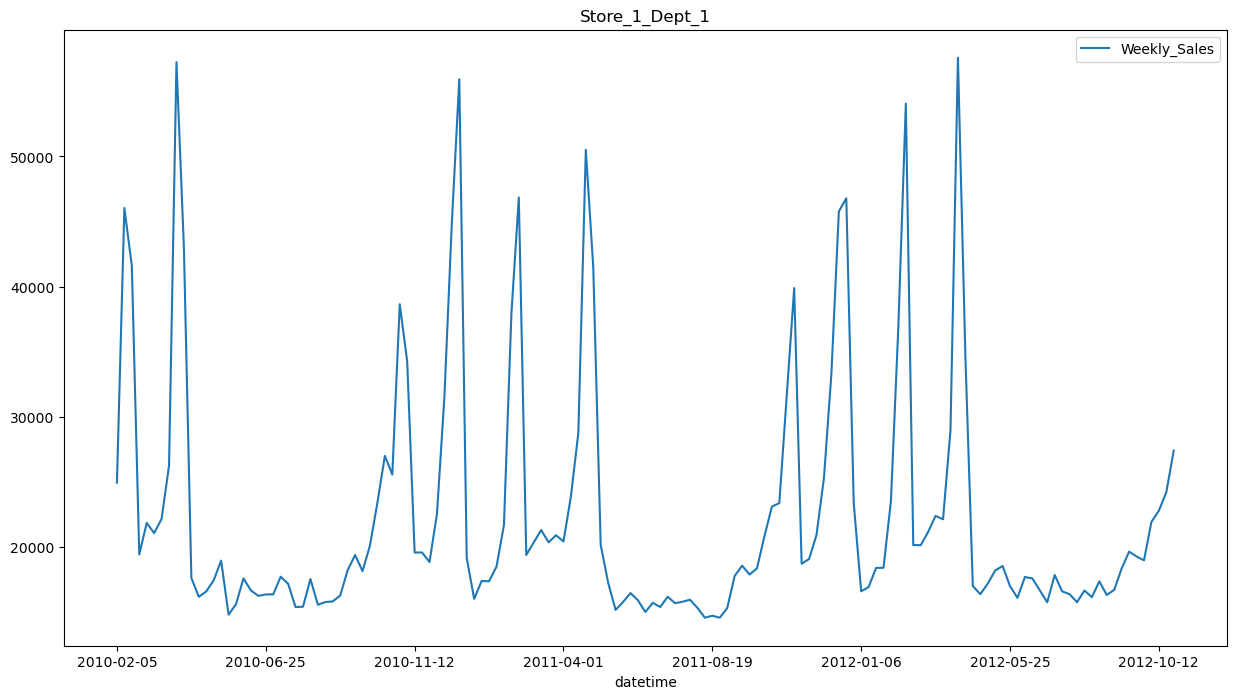

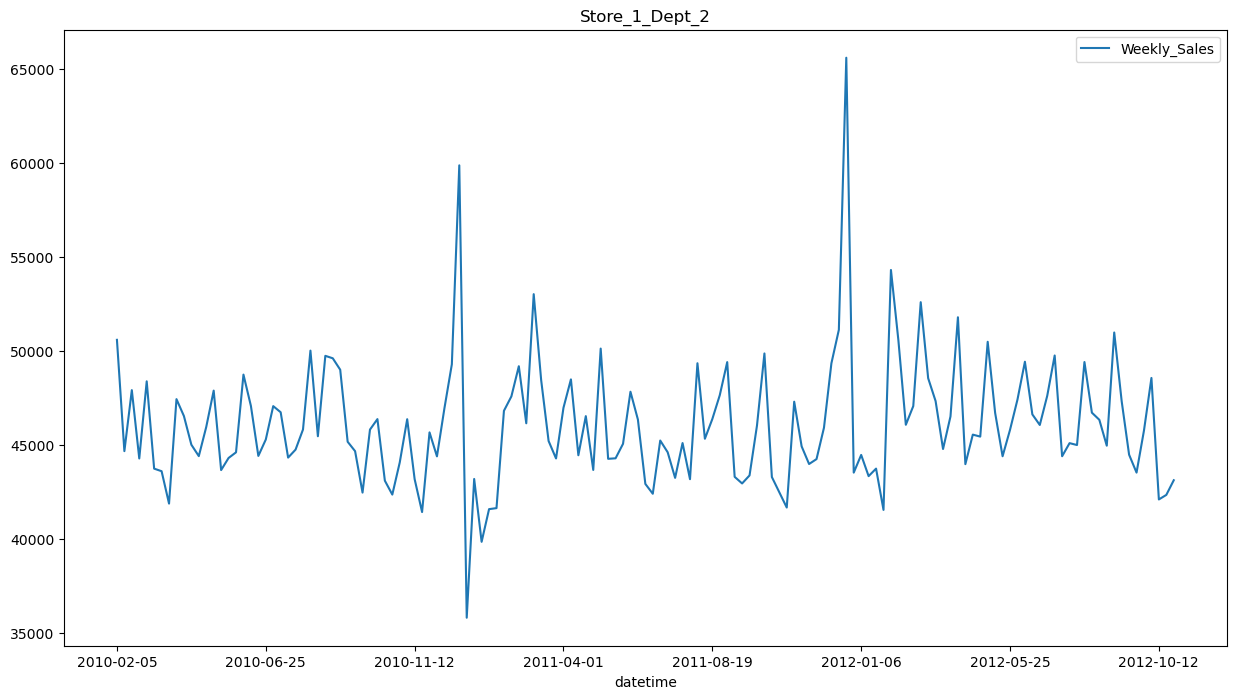

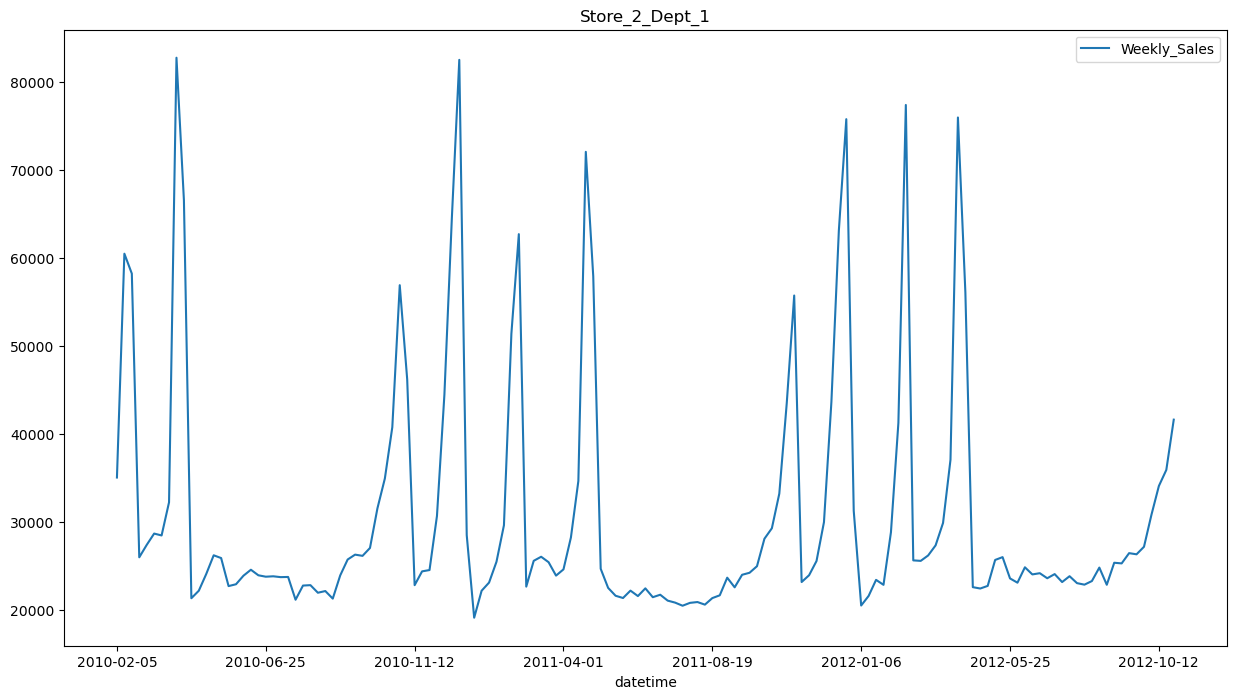

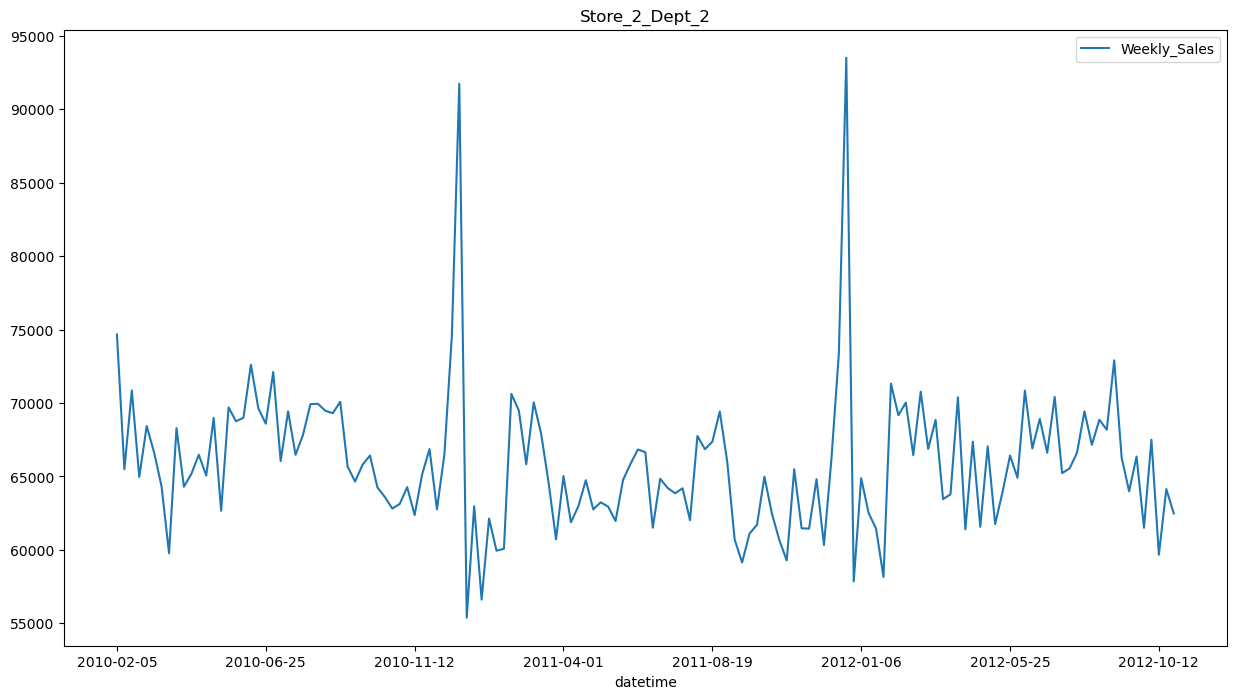

In [110]:
from tqdm import tqdm
all_ts = walmart['item_id'].unique()
for i in tqdm(all_ts):
    df_subset = walmart[walmart['item_id'] == i]
    df_subset.plot(x='datetime', y='Weekly_Sales',title=i, figsize=(15, 8))
    
    

In [111]:
#plt.figure(figsize=(15, 8))
#ax = plt.gca()
#bike_df_small.plot(x='datetime', y='count', ax=ax);
#ax2 = ax.twinx()
#bike_df_small.plot(x='datetime', y='workingday', color='red', ax=ax2);

In [367]:
# what is your forecast horizon in number time units you've selected?
# e.g. if you're forecasting in hours, how many months out do you want a forecast?
FORECAST_LENGTH = 20

# What is your forecast time unit granularity?
# Choices are: ^Y|M|W|D|H|30min|15min|10min|5min|1min$ 
DATASET_FREQUENCY = "W"
TIMESTAMP_FORMAT = "yyyy-MM-dd"
# delimiter = ','

# What name do you want to give this project?  
# We will use this same name for your Forecast Dataset Group name.
PROJECT = 'wal_demo'
DATA_VERSION = 4

In [172]:
target_df = walmart[['item_id', 'datetime', 'Weekly_Sales']][:-FORECAST_LENGTH]
target_df.head(5)

,item_id,datetime,Weekly_Sales
0,Store_1_Dept_1,2010-02-05,24924.50
1,Store_1_Dept_2,2010-02-05,50605.27
2,Store_1_Dept_2,2010-02-12,44682.74
3,Store_1_Dept_1,2010-02-12,46039.49
4,Store_1_Dept_2,2010-02-19,47928.89


In [173]:
print(target_df.datetime.min())
print(target_df.datetime.max())

2010-02-05
2012-10-26


In [174]:
walmart.columns

Index(['datetime', 'IsHoliday', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'CPI', 'Unemployment', 'Type', 'Size', 'item_id'],
      dtype='object')

In [175]:
rts_df = walmart[['item_id', 'datetime','IsHoliday','Temperature', 'Fuel_Price',
       'MarkDown1', 'CPI', 'Unemployment', 'Type', 'Size']]
rts_df.head(5)

,item_id,datetime,IsHoliday,Temperature,Fuel_Price,MarkDown1,CPI,Unemployment,Type,Size
0,Store_1_Dept_1,2010-02-05,0,42.31,2.572,0,211.0963582,8.106,3,151315
1,Store_1_Dept_2,2010-02-05,0,42.31,2.572,0,211.0963582,8.106,3,151315
2,Store_1_Dept_2,2010-02-12,1,38.51,2.548,0,211.2421698,8.106,3,151315
3,Store_1_Dept_1,2010-02-12,1,38.51,2.548,0,211.2421698,8.106,3,151315
4,Store_1_Dept_2,2010-02-19,0,39.93,2.514,0,211.2891429,8.106,3,151315


In [368]:
print(f"{len(target_df)} + {FORECAST_LENGTH} = {len(rts_df)}")
assert len(target_df) + FORECAST_LENGTH == len(rts_df), "length doesn't match"

552 + 10 = 572


AssertionError: length doesn't match

In [177]:
#assert len(rts_df) == len(pd.date_range(
#    start=list(rts_df['datetime'])[0],
#    end=list(rts_df['datetime'])[-1],
#    freq='W'
#)), "missing entries in the related time series"

In [178]:
target_df.to_csv("walmart_target.csv", index= False, header = False)
rts_df.to_csv("walmart_rts.csv", index= False, header = False)

In [179]:
key = "walmart"

s3.upload_file(Filename="walmart_target.csv", Bucket = bucket_name, Key = f"{key}/walmart_target.csv")
s3.upload_file(Filename="walmart_rts.csv", Bucket = bucket_name, Key = f"{key}/walmart_rts.csv")

In [180]:
dataset_group = f"{PROJECT}_{DATA_VERSION}"
print(f"Dataset Group Name = {dataset_group}")

Dataset Group Name = wal_demo_4


In [181]:
dataset_arns = []
create_dataset_group_response = \
    forecast.create_dataset_group(Domain="RETAIL",
                                  DatasetGroupName=dataset_group,
                                  DatasetArns=dataset_arns)

In [182]:
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

In [183]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

{'DatasetGroupName': 'wal_demo_4',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:754307369999:dataset-group/wal_demo_4',
 'DatasetArns': [],
 'Domain': 'RETAIL',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2023, 6, 15, 5, 31, 20, 681000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2023, 6, 15, 5, 31, 20, 681000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'c45d6423-531f-41d1-b9a2-9e0486a6cabb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 15 Jun 2023 05:31:21 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '243',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c45d6423-531f-41d1-b9a2-9e0486a6cabb'},
  'RetryAttempts': 0}}

In [184]:
#Target time series data

In [185]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
ts_schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"demand",
         "AttributeType":"float"
      }
   ]
}

In [186]:
ts_dataset_name = f"{PROJECT}_{DATA_VERSION}_tts1"
print(ts_dataset_name)

wal_demo_4_tts1


In [187]:
response = \
    forecast.create_dataset(Domain="RETAIL",
                            DatasetType='TARGET_TIME_SERIES',
                            DatasetName=ts_dataset_name,
                            DataFrequency=DATASET_FREQUENCY,
                            Schema=ts_schema
                           )

In [188]:
ts_dataset_arn = response['DatasetArn']

In [189]:
forecast.describe_dataset(DatasetArn=ts_dataset_arn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:754307369999:dataset/wal_demo_4_tts1',
 'DatasetName': 'wal_demo_4_tts1',
 'Domain': 'RETAIL',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'W',
 'Schema': {'Attributes': [{'AttributeName': 'item_id',
    'AttributeType': 'string'},
   {'AttributeName': 'timestamp', 'AttributeType': 'timestamp'},
   {'AttributeName': 'demand', 'AttributeType': 'float'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2023, 6, 15, 5, 31, 23, 904000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2023, 6, 15, 5, 31, 23, 904000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'a907a58f-f393-4242-bff0-bfb07fb4e1fc',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 15 Jun 2023 05:31:25 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '485',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'a907a58f-f393-4242-bff0-bfb07fb4e1fc'},
  'RetryAttempts': 0}}

In [190]:
#Related Schema

In [191]:
rts_df.columns

Index(['item_id', 'datetime', 'IsHoliday', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [192]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
rts_schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"IsHoliday",
         "AttributeType":"float"
      },
       {
         "AttributeName":"Temperature",
         "AttributeType":"float"
      },
       {
         "AttributeName":"Fuel_Price",
         "AttributeType":"float"
      },
       {
         "AttributeName":"MarkDown1",
         "AttributeType":"float"
      },
       {
         "AttributeName":"CPI",
         "AttributeType":"float"
      },
       {
         "AttributeName":"Unemployment",
         "AttributeType":"float"
      },
       {
         "AttributeName":"Types",
         "AttributeType":"float"
      },
       {
         "AttributeName":"area",
         "AttributeType":"float"
      }
   ]
}

In [193]:
rts_dataset_name = f"{PROJECT}_{DATA_VERSION}_rts1"
print(rts_dataset_name)

wal_demo_4_rts1


In [194]:
response = \
    forecast.create_dataset(Domain="RETAIL",
                            DatasetType='RELATED_TIME_SERIES',
                            DatasetName=rts_dataset_name,
                            DataFrequency=DATASET_FREQUENCY,
                            Schema=rts_schema
                           )

In [195]:
rts_dataset_arn = response['DatasetArn']

In [196]:

forecast.describe_dataset(DatasetArn=rts_dataset_arn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:754307369999:dataset/wal_demo_4_rts1',
 'DatasetName': 'wal_demo_4_rts1',
 'Domain': 'RETAIL',
 'DatasetType': 'RELATED_TIME_SERIES',
 'DataFrequency': 'W',
 'Schema': {'Attributes': [{'AttributeName': 'item_id',
    'AttributeType': 'string'},
   {'AttributeName': 'timestamp', 'AttributeType': 'timestamp'},
   {'AttributeName': 'IsHoliday', 'AttributeType': 'float'},
   {'AttributeName': 'Temperature', 'AttributeType': 'float'},
   {'AttributeName': 'Fuel_Price', 'AttributeType': 'float'},
   {'AttributeName': 'MarkDown1', 'AttributeType': 'float'},
   {'AttributeName': 'CPI', 'AttributeType': 'float'},
   {'AttributeName': 'Unemployment', 'AttributeType': 'float'},
   {'AttributeName': 'Types', 'AttributeType': 'float'},
   {'AttributeName': 'area', 'AttributeType': 'float'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2023, 6, 15, 5, 31, 29, 708000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.

In [197]:
dataset_arns = []
dataset_arns.append(ts_dataset_arn)
dataset_arns.append(rts_dataset_arn)
forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

{'ResponseMetadata': {'RequestId': 'df70e8e2-d9bb-4f2b-bbff-a24714683d25',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 15 Jun 2023 05:31:32 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'df70e8e2-d9bb-4f2b-bbff-a24714683d25'},
  'RetryAttempts': 0}}

In [198]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

{'DatasetGroupName': 'wal_demo_4',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:754307369999:dataset-group/wal_demo_4',
 'DatasetArns': ['arn:aws:forecast:us-east-1:754307369999:dataset/wal_demo_4_tts1',
  'arn:aws:forecast:us-east-1:754307369999:dataset/wal_demo_4_rts1'],
 'Domain': 'RETAIL',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2023, 6, 15, 5, 31, 20, 681000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2023, 6, 15, 5, 31, 32, 345000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '328f85b4-8620-45f3-8ac8-1eb579369828',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 15 Jun 2023 05:31:33 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '374',
   'connection': 'keep-alive',
   'x-amzn-requestid': '328f85b4-8620-45f3-8ac8-1eb579369828'},
  'RetryAttempts': 0}}

In [199]:
#Step 4. Create the Target Time Series Data Import Job

In [200]:
s3_data_path = f"s3://{bucket_name}/{key}"

In [201]:
ts_s3_data_path = f"{s3_data_path}/walmart_target.csv"

In [202]:
ts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                       DatasetArn=ts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": ts_s3_data_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT)

In [203]:
ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']

In [204]:
# status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
# assert status

In [205]:
rts_s3_data_path = f"{s3_data_path}/walmart_rts.csv"

In [206]:

rts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                       DatasetArn=rts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": rts_s3_data_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT)

In [207]:
rts_dataset_import_job_arn=rts_dataset_import_job_response['DatasetImportJobArn']

In [208]:
#Choosing an algorithm and evaluating its performance

In [209]:
#Train a DeepAR+ Predictor

In [210]:
# Which algorithm do you want to use?  Choices are:
# 1. Choose PerformAutoML=True if you want to let Amazon Forecast choose a recipe automatically.  
# 2. If you know which recipe you want, the next level of automation is PerformHPO=True.
# 3. Finally, you can specify exactly which recipe and enter your own hyperparameter values
# https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html

algorithm_arn = 'arn:aws:forecast:::algorithm/'
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_deep_ar}")

Predictor Name = wal_demo_4_deep_ar_plus


In [213]:
create_predictor_response = \
    forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                              AlgorithmArn=algorithm_arn_deep_ar_plus,
                              ForecastHorizon=FORECAST_LENGTH,
                              PerformAutoML=False,
                              PerformHPO=False,
                              InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                              FeaturizationConfig= {"ForecastFrequency": DATASET_FREQUENCY}
                             )

In [216]:
predictor_arn_deep_ar = create_predictor_response['PredictorArn']

In [217]:
forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)

{'PredictorArn': 'arn:aws:forecast:us-east-1:754307369999:predictor/wal_demo_4_deep_ar_plus',
 'PredictorName': 'wal_demo_4_deep_ar_plus',
 'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
 'ForecastHorizon': 20,
 'ForecastTypes': ['0.1', '0.5', '0.9'],
 'PerformAutoML': False,
 'PerformHPO': False,
 'EvaluationParameters': {'NumberOfBacktestWindows': 1,
  'BackTestWindowOffset': 20},
 'InputDataConfig': {'DatasetGroupArn': 'arn:aws:forecast:us-east-1:754307369999:dataset-group/wal_demo_4'},
 'FeaturizationConfig': {'ForecastFrequency': 'W',
  'Featurizations': [{'AttributeName': 'demand',
    'FeaturizationPipeline': [{'FeaturizationMethodName': 'filling',
      'FeaturizationMethodParameters': {'aggregation': 'sum',
       'backfill': 'zero',
       'frontfill': 'none',
       'middlefill': 'zero'}}]},
   {'AttributeName': 'IsHoliday',
    'FeaturizationPipeline': [{'FeaturizationMethodName': 'filling',
      'FeaturizationMethodParameters': {'aggregation': 'first',
     

In [ ]:
#Train a Prophet Predictor

In [219]:
# Which algorithm do you want to use?  Choices are:
# 1. Choose PerformAutoML=True if you want to let Amazon Forecast choose a recipe automatically.  
# 2. If you know which recipe you want, the next level of automation is PerformHPO=True.
# 3. Finally, you can specify exactly which recipe and enter your own hyperparameter values
# https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html

algorithm = 'Prophet'
algorithm_arn_prophet = algorithm_arn + algorithm
# predictor_name_prophet = f'{project}_{algorithm.lower()}_{idx}'
predictor_name_prophet = f"{PROJECT}_{DATA_VERSION}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_prophet}")

Predictor Name = wal_demo_4_prophet


In [220]:
create_predictor_response = \
    forecast.create_predictor(PredictorName=predictor_name_prophet,
                              AlgorithmArn=algorithm_arn_prophet,
                              ForecastHorizon=FORECAST_LENGTH,
                              PerformAutoML=False,
                              PerformHPO=False,
                              InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                              FeaturizationConfig= {"ForecastFrequency": DATASET_FREQUENCY}
                             )

In [221]:
predictor_arn_prophet = create_predictor_response['PredictorArn']

In [222]:
#Get Predictor Error Metrics from Backtesting

In [224]:
error_metrics_deep_ar_plus = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
error_metrics_deep_ar_plus

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 19504.68138405195,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.2256069701888411},
       {'Quantile': 0.5, 'LossValue': 0.5053990624916552},
       {'Quantile': 0.1, 'LossValue': 0.5229546752932092}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.5028227305075927,
        'RMSE': 19504.68138405195,
        'MASE': 5.616780987093453,
        'MAPE': 0.1542208510722862}],
      'AverageWeightedQuantileLoss': 0.4179869026579019}},
    {'TestWindowStart': datetime.datetime(2012, 6, 15, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2012, 11, 2, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 4,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 19504.681384051954,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.2256069701888411}

In [225]:
error_metrics_prophet = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_prophet)
error_metrics_prophet

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 25296.280228328633,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.13524660022845778},
       {'Quantile': 0.5, 'LossValue': 0.47297259294109756},
       {'Quantile': 0.1, 'LossValue': 0.6634827560773825}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.4715736701405313,
        'RMSE': 25296.280228328633,
        'MASE': 4.63183213767528,
        'MAPE': 0.04586082729169283}],
      'AverageWeightedQuantileLoss': 0.42390064974897923}},
    {'TestWindowStart': datetime.datetime(2012, 6, 15, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2012, 11, 2, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 4,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 25296.280228328633,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.13524660022845778

In [226]:
def extract_summary_metrics(metric_response, predictor_name):
    df = pd.DataFrame(metric_response['PredictorEvaluationResults']
                 [0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses'])
    df['Predictor'] = predictor_name
    return df

In [227]:
deep_ar_metrics = extract_summary_metrics(error_metrics_deep_ar_plus, "DeepAR")
prophet_metrics = extract_summary_metrics(error_metrics_prophet, "Prophet")

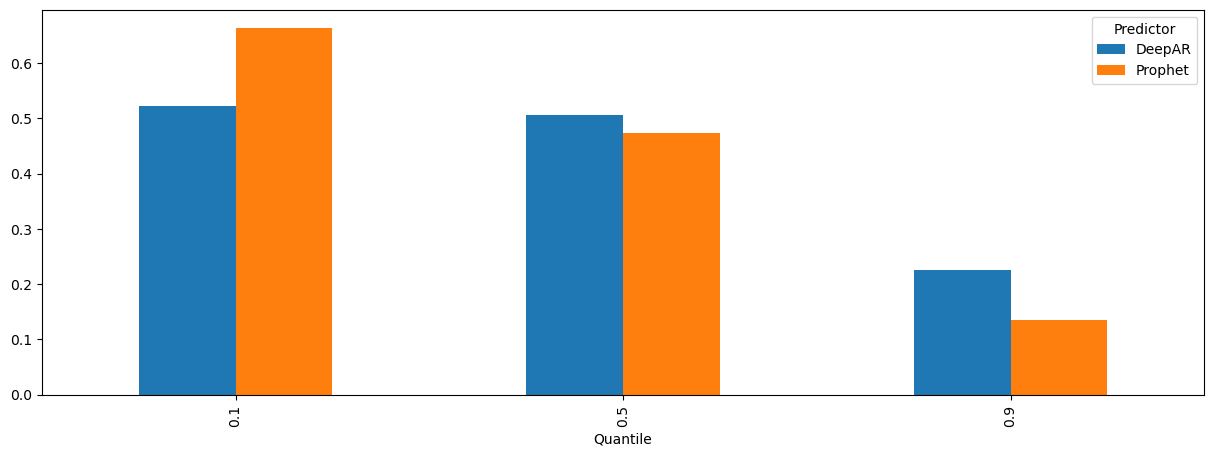

In [228]:
pd.concat([deep_ar_metrics, prophet_metrics]) \
    .pivot(index='Quantile', columns='Predictor', values='LossValue').plot.bar();

#Create a forecast

In [250]:
#DeepAR

In [229]:
forecast_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_deeparp"
print(f"Forecast Name = {forecast_name_deep_ar}")

Forecast Name = wal_demo_4_deeparp


In [230]:
create_forecast_response_deep_ar = forecast.create_forecast(ForecastName=forecast_name_deep_ar,
                                                        PredictorArn=predictor_arn_deep_ar)

In [247]:
forecast_arn_deep_ar = create_forecast_response_deep_ar['ForecastArn']

In [248]:
forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)

{'ForecastArn': 'arn:aws:forecast:us-east-1:754307369999:forecast/wal_demo_4_deeparp',
 'ForecastName': 'wal_demo_4_deeparp',
 'ForecastTypes': ['0.1', '0.5', '0.9'],
 'PredictorArn': 'arn:aws:forecast:us-east-1:754307369999:predictor/wal_demo_4_deep_ar_plus',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:754307369999:dataset-group/wal_demo_4',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2023, 6, 15, 6, 19, 3, 64000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2023, 6, 15, 6, 32, 12, 831000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'fb8455d4-b0d0-439f-ba8a-c0d466e20fe8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 15 Jun 2023 07:59:22 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '423',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'fb8455d4-b0d0-439f-ba8a-c0d466e20fe8'},
  'RetryAttempts': 0}}

In [251]:
#Prophet

In [262]:
forecast_name_prophet = f"{PROJECT}_{DATA_VERSION}_prophet"
print(f"Forecast Name = {forecast_name_prophet}")

Forecast Name = wal_demo_4_prophet


In [254]:
create_forecast_response_prophet = forecast.create_forecast(ForecastName=forecast_name_prophet,
                                                        PredictorArn=predictor_arn_prophet)

In [255]:
forecast_arn_prophet = create_forecast_response_prophet['ForecastArn']

In [256]:

forecast.describe_forecast(ForecastArn=forecast_arn_prophet)

{'ForecastArn': 'arn:aws:forecast:us-east-1:754307369999:forecast/wal_demo_4_prophet',
 'ForecastName': 'wal_demo_4_prophet',
 'ForecastTypes': ['0.1', '0.5', '0.9'],
 'PredictorArn': 'arn:aws:forecast:us-east-1:754307369999:predictor/wal_demo_4_prophet',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:754307369999:dataset-group/wal_demo_4',
 'Status': 'CREATE_PENDING',
 'CreationTime': datetime.datetime(2023, 6, 15, 8, 1, 24, 45000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2023, 6, 15, 8, 1, 24, 45000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '6d11703a-b369-4510-9849-ecdcd856eef2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 15 Jun 2023 08:01:40 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '426',
   'connection': 'keep-alive',
   'x-amzn-requestid': '6d11703a-b369-4510-9849-ecdcd856eef2'},
  'RetryAttempts': 0}}

In [257]:
#Query a forecast

In [346]:
item_id = 'Store_1_Dept_1'

In [358]:
forecast_response_deep = forecastquery.query_forecast(
    ForecastArn=forecast_arn_deep_ar,
    Filters={"item_id": item_id})

In [359]:
forecast_response_prophet = forecastquery.query_forecast(ForecastArn=forecast_arn_prophet,
                                                     Filters={"item_id":item_id})

In [366]:
forecast_response_prophet

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2012-10-29T00:00:00',
     'Value': 26271.89710660622},
    {'Timestamp': '2012-11-05T00:00:00', 'Value': 19982.88449896252},
    {'Timestamp': '2012-11-12T00:00:00', 'Value': 12218.4816991683},
    {'Timestamp': '2012-11-19T00:00:00', 'Value': 11447.31353520813},
    {'Timestamp': '2012-11-26T00:00:00', 'Value': 15745.738393797059},
    {'Timestamp': '2012-12-03T00:00:00', 'Value': 27491.212314658176},
    {'Timestamp': '2012-12-10T00:00:00', 'Value': 35522.41831397336},
    {'Timestamp': '2012-12-17T00:00:00', 'Value': 34711.93452595657},
    {'Timestamp': '2012-12-24T00:00:00', 'Value': 27504.99135552058},
    {'Timestamp': '2012-12-31T00:00:00', 'Value': 16185.535230830443},
    {'Timestamp': '2013-01-07T00:00:00', 'Value': 5674.407509385177},
    {'Timestamp': '2013-01-14T00:00:00', 'Value': 4665.435440974554},
    {'Timestamp': '2013-01-21T00:00:00', 'Value': 10473.56834738423},
    {'Timestamp': '2013-01-28T00:00:00', 'Value':

In [360]:
fname = f'walmart_target.csv'


In [361]:
exact = util.fcst_utils.load_exact_sol(fname, item_id)

In [369]:
exact

,item_id,timestamp,target
0,Store_1_Dept_1,2010-02-05,24924.50
3,Store_1_Dept_1,2010-02-12,46039.49
5,Store_1_Dept_1,2010-02-19,41595.55
7,Store_1_Dept_1,2010-02-26,19403.54
8,Store_1_Dept_1,2010-03-05,21827.90
...,...,...,...
277,Store_1_Dept_1,2012-09-28,18947.81
279,Store_1_Dept_1,2012-10-05,21904.47
281,Store_1_Dept_1,2012-10-12,22764.01
283,Store_1_Dept_1,2012-10-19,24185.27


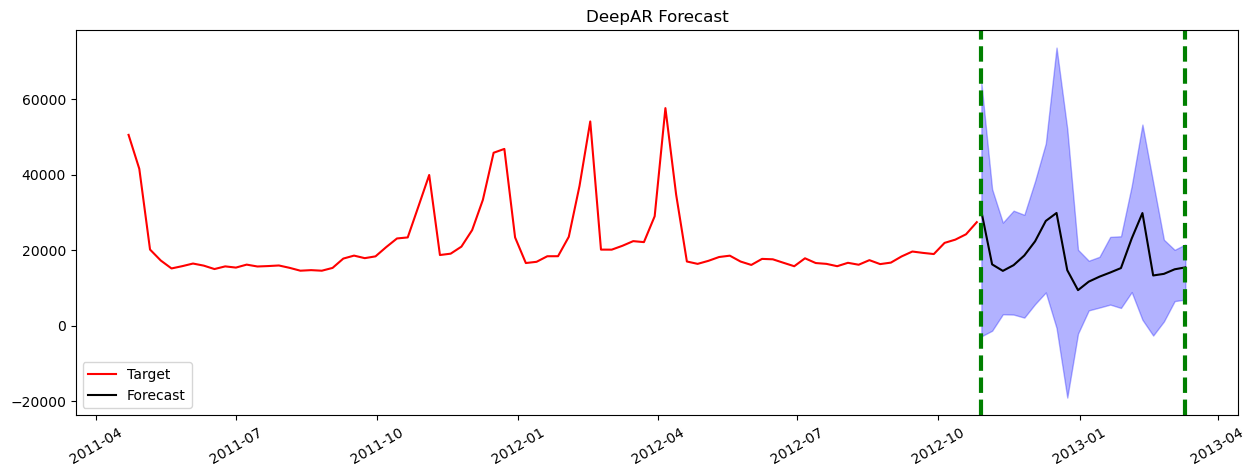

In [362]:
util.fcst_utils.plot_forecasts(forecast_response_deep, exact)
plt.title("DeepAR Forecast");

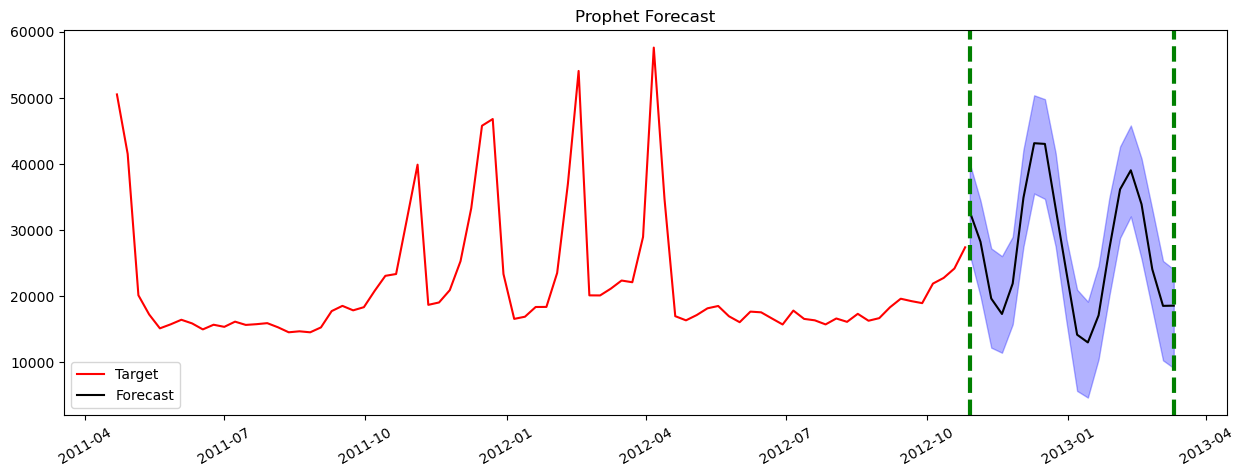

In [357]:
util.fcst_utils.plot_forecasts(forecast_response_prophet,exact)
plt.title("Prophet Forecast");

In [282]:
#EXport a forecast

In [283]:
forecast_export_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_forecast_export_deeparp"
forecast_export_name_deep_ar_path = f"{s3_data_path}/{forecast_export_name_deep_ar}"

In [286]:
create_forecast_export_response_deep_ar = \
    forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_deep_ar,
                                        ForecastArn=forecast_arn_deep_ar,
                                        Destination={
                                            "S3Config" : {
                                                "Path": forecast_export_name_deep_ar_path,
                                                "RoleArn": role_arn
                                            }
                                        })
forecast_export_arn_deep_ar = create_forecast_export_response_deep_ar['ForecastExportJobArn']

In [287]:
forecast_export_name_prophet = f"{PROJECT}_{DATA_VERSION}_forecast_export_prophet"
forecast_export_name_prophet_path = f"{s3_data_path}/{forecast_export_name_prophet}"

In [288]:
create_forecast_export_response_prophet = \
    forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_prophet,
                                        ForecastArn=forecast_arn_prophet,
                                        Destination={
                                            "S3Config" : {
                                                "Path": forecast_export_name_prophet_path,
                                                "RoleArn": role_arn
                                            }
                                        })
forecast_export_arn_prophet = create_forecast_export_response_prophet['ForecastExportJobArn']

In [289]:
#REading Backtest data

In [302]:
forecast_export_name_deep_ar_path

's3://forecast-amita/walmart/wal_demo_4_forecast_export_deeparp'

In [305]:
# path to files is everything after BUCKET_NAME/, it should end in "/"
s3_path_to_files = forecast_export_name_deep_ar_path.split(bucket_name)[1][1:]
s3_path_to_files = s3_path_to_files + "/accuracy-metrics-values/"
print(f"path to files: {s3_path_to_files}")

path to files: walmart/wal_demo_4_forecast_export_deeparp/accuracy-metrics-values/
